# **1.0 INTRODUCTION**
The aim of this project is to utilise ***reinforcement learning*** to train a machine to learn how to rebalance a portfolio of stocks given what happened prior in the market. For this project, our portfilio will initially focus on the ***Dow Jones Index*** of **30 constituents**.

### **1.1 Import Dependencies**

In [131]:
import yfinance as yf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np

### **1.2 Data Preparation**
We'll select the stocks from the DOW JONES for our analysis.

In [2]:
DOW_30_TICKERS = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW"
]

We'll make dictionaries for each ticker and store financial data within them. 
<br><br>
We'll focus on ticker name, the yahoo finance object, info and historical prices over the past ***10 years***.
<br><br>
For each ticker, the financial information will be represented by a dataframe.


In [4]:
DOW_tickers_data = []
for ticker in DOW_30_TICKERS:
    ticker_dict = {
                   'ticker': ticker, 
                   'info': yf.Ticker(ticker).info,
                   'daily_prices':yf.download(ticker, period = '10y', interval = '1d')
                   }
    DOW_tickers_data.append(ticker_dict)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Here is an example of one of historical data for one of our constituents.

In [6]:
DOW_tickers_data[0]['daily_prices'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-26,57.750000,58.750000,57.599998,58.660000,50.817879,6341600
2012-03-27,59.000000,59.180000,58.209999,58.220001,50.436703,5683000
2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164410,7925900
2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600
2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124832,5779700


We'll now make a few changes to our dataframes.

In [31]:
# assign a column order for our dataframes
column_order = ['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume',	'tic', 'day']

for ticker in DOW_tickers_data:
    # make the index a datetime object
    ticker['daily_prices'] = ticker['daily_prices'].reset_index()
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Date': 'date'}, axis = 1)
    ticker['daily_prices']['date'] = pd.to_datetime(ticker['daily_prices']['date'])
    # add a column for 'day of the week'
    ticker['daily_prices']['day'] = ticker['daily_prices']['date'].dt.dayofweek
    # add the ticker name to the dataframe
    ticker['daily_prices']['tic'] = ticker['ticker']
    # rename the adjusted closing price column
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Adj Close': 'adjcp'}, axis = 1)
    # set a column order for our dataframes
    ticker['daily_prices'].columns= ticker['daily_prices'].columns.str.lower()
    ticker['daily_prices'] = ticker['daily_prices'][column_order]

In [33]:
DOW_tickers_data[0]['daily_prices']

,date,open,high,low,close,adjcp,volume,tic,day
0,2012-03-26,57.750000,58.750000,57.599998,58.660000,50.817879,6341600,AXP,0
1,2012-03-27,59.000000,59.180000,58.209999,58.220001,50.436703,5683000,AXP,1
2,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164410,7925900,AXP,2
3,2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600,AXP,3
4,2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124832,5779700,AXP,4
...,...,...,...,...,...,...,...,...,...
2513,2022-03-21,190.770004,191.500000,187.559998,189.089996,189.089996,3166200,AXP,0
2514,2022-03-22,190.500000,194.350006,190.059998,191.330002,191.330002,3007000,AXP,1
2515,2022-03-23,188.830002,189.619995,185.179993,186.020004,186.020004,3664600,AXP,2
2516,2022-03-24,186.610001,189.369995,185.699997,188.889999,188.889999,2424400,AXP,3


We'll now compile a list of the historical prices dataframes so we can create a ***panel dataset***.

In [36]:
DOW_tickers_prices = [ticker['daily_prices'] for ticker in DOW_tickers_data]

# And then compile them into a single dataframe
DOW_tickers_panel_dataset = pd.concat(DOW_tickers_prices)
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[column_order]
DOW_tickers_panel_dataset.head()

,date,open,high,low,close,adjcp,volume,tic,day
0,2012-03-26,57.750000,58.750000,57.599998,58.660000,50.817879,6341600.0,AXP,0
1,2012-03-27,59.000000,59.180000,58.209999,58.220001,50.436703,5683000.0,AXP,1
2,2012-03-28,58.380001,59.259998,58.380001,59.060001,51.164410,7925900.0,AXP,2
3,2012-03-29,58.279999,58.439999,57.240002,57.889999,50.150810,7397600.0,AXP,3
4,2012-03-30,58.180000,58.310001,57.540001,57.860001,50.124832,5779700.0,AXP,4


In [57]:
DOW_tickers_panel_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73729 entries, 0 to 761
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    73729 non-null  datetime64[ns]
 1   open    73728 non-null  float64       
 2   high    73728 non-null  float64       
 3   low     73728 non-null  float64       
 4   close   73728 non-null  float64       
 5   adjcp   73728 non-null  float64       
 6   volume  73728 non-null  float64       
 7   tic     73729 non-null  object        
 8   day     73729 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 5.6+ MB


We'll have a look to see if there are any na values.

In [59]:
DOW_tickers_panel_dataset[pd.isna(DOW_tickers_panel_dataset['open'])]

,date,open,high,low,close,adjcp,volume,tic,day
957,2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN,CAT,0


There does seem to be a single record that consists of na values for this particular stock. <br>
<br>
We'll deal with it using ***backfill***.

In [65]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.backfill()
DOW_tickers_panel_dataset.shape

(73729, 9)

So our panel dataset has over 73,000 rows with 9 columns and one of those columns includes the ticker name.
<br><br>
We'll now export this dataframe into a csv.

In [66]:
DOW_tickers_panel_dataset.to_csv('data/DOW_tickers_panel_dataset.csv', index=True)

### **1.3 EDA**
With our panel dataset created, we can now perform simple EDA and data visualisations.

We can visualise the median changes in price across the years.

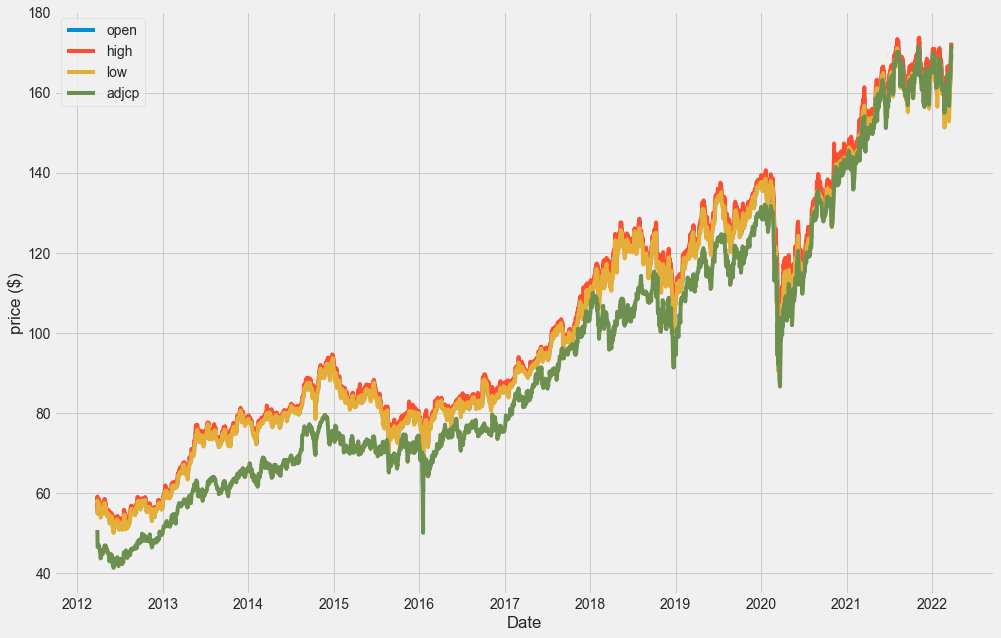

In [107]:
median_panel_dataset = DOW_tickers_panel_dataset.groupby('date').median().reset_index()

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(median_panel_dataset['date'], median_panel_dataset['open'], label = 'open')
ax.plot(median_panel_dataset['date'], median_panel_dataset['high'], label = 'high')
ax.plot(median_panel_dataset['date'], median_panel_dataset['low'], label = 'low')
ax.plot(median_panel_dataset['date'], median_panel_dataset['adjcp'], label = 'adjcp')
ax.set_ylabel('price ($)')
ax.set_xlabel('Date')
plt.legend();

A more important metric would be viewing average ***ROI***.
<br><br>
We'll firstly calculate it per ticker.

In [150]:
ROI_df_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    df['ROI'] = df['adjcp'].pct_change()
    df = df.dropna()
    ROI_df_list.append(df)

<ipython-input-150-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-150-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-150-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

We'll then turn list of dataframes into a single panel set and calculate the median ROI.

In [151]:
ROI_panel = pd.concat(ROI_df_list)
median_ROI_panel = ROI_panel.groupby('date').median().reset_index()

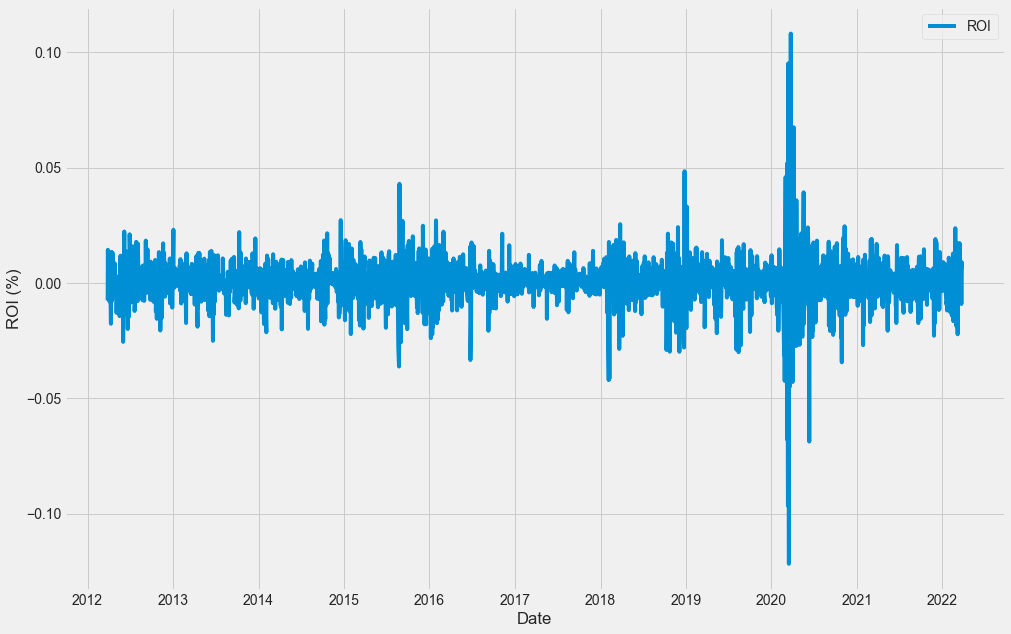

In [152]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(median_ROI_panel['date'], median_ROI_panel['ROI'], label = 'ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Date')
plt.legend();

The median ROI is relatively stable throughout the 10 years apart from around early 2020 due to covid and lockdown rules.
<br><br>
What we can do now is look at the top performing tickers over a range of time periods:
- ***1 month***
- ***6 month***
- ***1 year***

In [174]:
ROI_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    # we'll take the prior values for each time period
    month_1_prior = df.iloc[-22]['adjcp']
    month_6_prior = df.iloc[-(22 * 6)]['adjcp']
    year_1_prior = df.iloc[-(22 * 12)]['adjcp']
    current_value = df.iloc[-1]['adjcp']
    # now we'll calculate the ROIs
    month_1_ROI = ((100 / month_1_prior) * current_value) - 100
    month_6_ROI = ((100 / month_6_prior) * current_value) - 100
    year_1_ROI = ((100 / year_1_prior) * current_value) - 100

    summary_dict = {'ticker': ticker,
                    'month_1_ROI': month_1_ROI, 
                    'month_6_ROI': month_6_ROI,
                    'year_1_ROI': year_1_ROI}

    ROI_list.append(summary_dict)

In [175]:
ROI_df = pd.DataFrame(ROI_list)
ROI_df.head()

,ticker,month_1_ROI,month_6_ROI,year_1_ROI
0,AXP,1.024684,16.661649,30.157056
1,AMGN,8.902261,8.847656,4.022580
2,AAPL,7.361433,19.622076,43.503429
3,BA,-4.777501,-11.440759,-25.019842
4,CAT,20.937786,12.982769,3.713072


**1 month ROI**

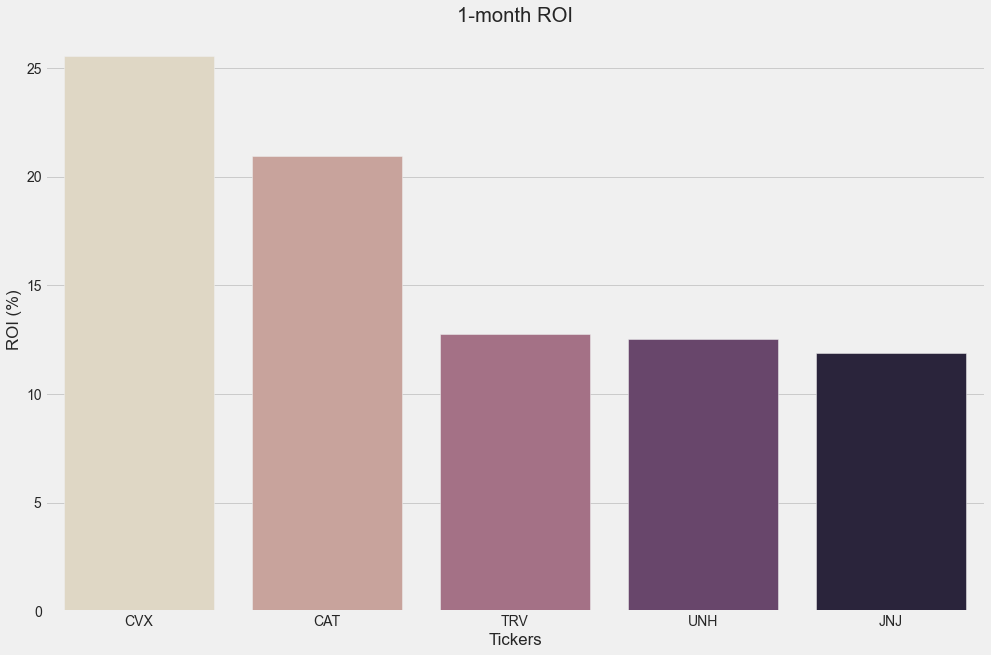

In [203]:
fig, ax = plt.subplots(figsize = (15, 10))
month_1_ROI_df = ROI_df[['ticker', 'month_1_ROI']].sort_values('month_1_ROI', ascending = False).head()
ax = sns.barplot(data = month_1_ROI_df, 
                x = 'ticker', 
                y = 'month_1_ROI',
                palette = sns.color_palette('ch:s=-.2,r=.6', n_colors=5))
ax.set_title('1-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**6 month ROI**

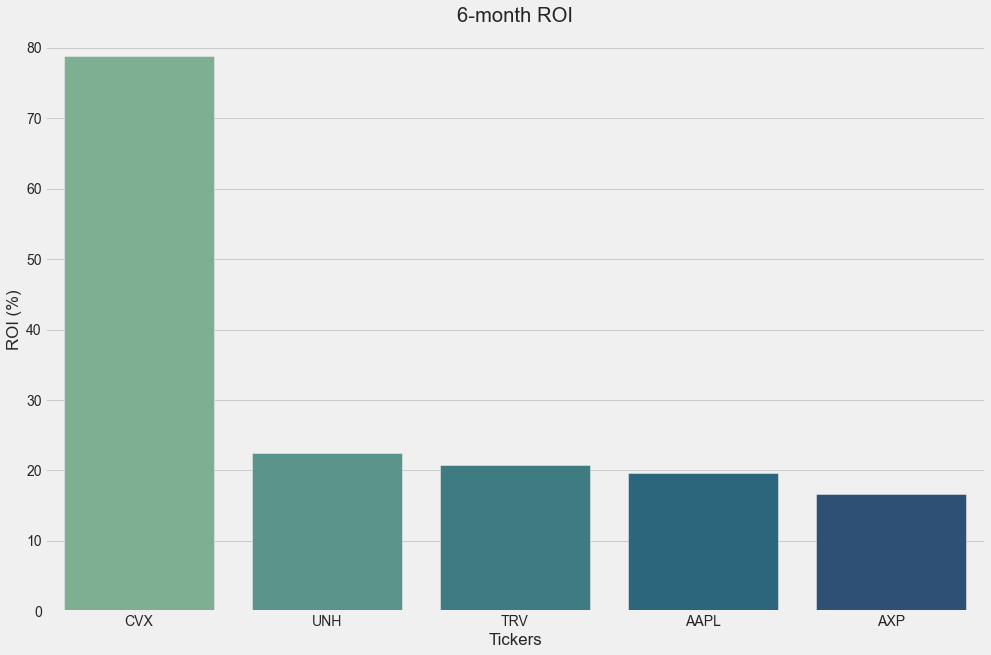

In [204]:
fig, ax = plt.subplots(figsize = (15, 10))
month_6_ROI_df = ROI_df[['ticker', 'month_6_ROI']].sort_values('month_6_ROI', ascending = False).head()
ax = sns.barplot(data = month_6_ROI_df, 
                x = 'ticker', 
                y = 'month_6_ROI',
                palette = sns.color_palette('crest', n_colors=5))
ax.set_title('6-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**1 year ROI**

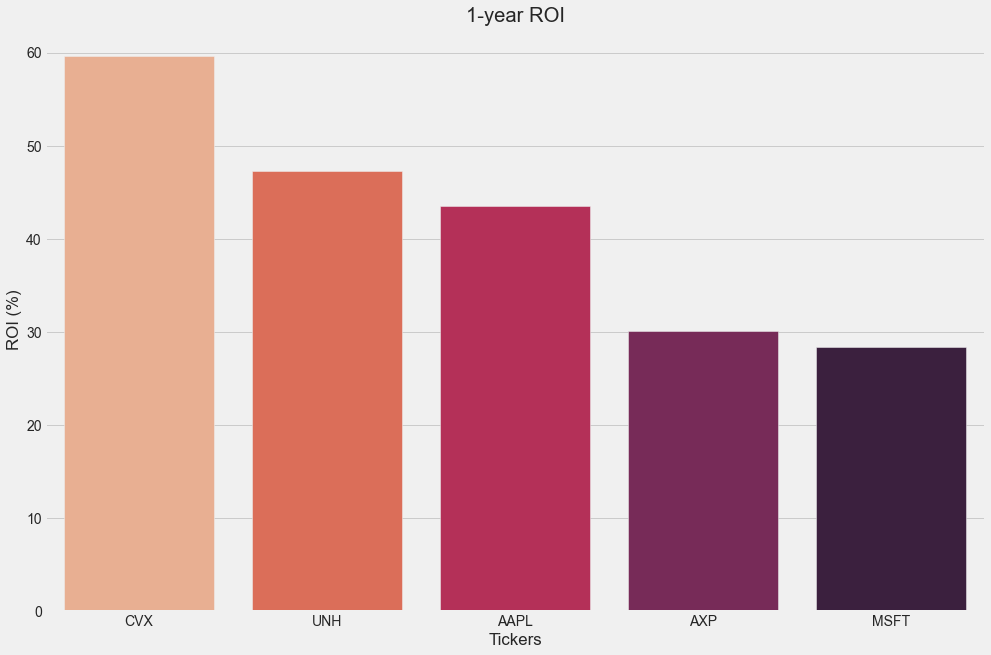

In [205]:
fig, ax = plt.subplots(figsize = (15, 10))
year_1_ROI_df = ROI_df[['ticker', 'year_1_ROI']].sort_values('year_1_ROI', ascending = False).head()
ax = sns.barplot(data = year_1_ROI_df, 
                x = 'ticker', 
                y = 'year_1_ROI', 
                palette = sns.color_palette('rocket_r', n_colors=5))
ax.set_title('1-year ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

Interestingly, we see the same ***CVX*** stock appear as the top performing stocks in each time period.

# **2.0 Data Preparation**